## 데이터 준비

In [1]:
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
train = datasets.MNIST(
    '../data', train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor()
    ])
)
test = datasets.MNIST(
    '../data', train=False,
    transform=transforms.Compose([
        transforms.ToTensor()
    ])
)

x = train.data.float() / 255
y = train.targets

x = x.view(x.size(0), -1)
print(x.shape, y.shape)

input_size = x.size(-1)
output_size = int(max(y)) + 1

print('input_size:%d, output_size:%d' % (input_size, output_size))

torch.Size([60000, 784]) torch.Size([60000])
input_size:784, output_size:10


In [3]:
# Train/ valid ratio
ratios = [.8, .2]

train_cnt = int(x.size(0) * ratios[0])
valid_cnt = int(x.size(0) * ratios[1])
test_cnt = len(test.data)
cnts = [train_cnt, valid_cnt]

print('Train %d / Valid %d / Test %d samples.' % (train_cnt, valid_cnt, test_cnt))

indices = torch.randperm(x.size(0))

x = torch.index_select(x, dim=0, index=indices)
y = torch.index_select(y, dim=0, index=indices)

x = list(x.split(cnts, dim=0))
y = list(y.split(cnts, dim=0))

x += [(test.data.float() / 255.).view(test_cnt, -1)]
y += [test.targets]

for x_i, y_i in zip(x,y):
    print(x_i.size(), y_i.size())

Train 48000 / Valid 12000 / Test 10000 samples.
torch.Size([48000, 784]) torch.Size([48000])
torch.Size([12000, 784]) torch.Size([12000])
torch.Size([10000, 784]) torch.Size([10000])


## 학습 코드 구현

In [4]:
class Block(nn.Module):
    
    def __init__(self,
                input_size,
                output_size,
                use_batch_norm = True,
                dropout_p = .4):
        self.input_size = input_size
        self.output_size = output_size
        self.use_batch_norm = use_batch_norm
        self.dropout_p = dropout_p

        super().__init__()

        def get_regularizer(use_batch_norm, size):
            return nn.BatchNorm1d(size) if use_batch_norm else nn.Dropout(dropout_p)

        self.block = nn.Sequential(
            nn.Linear(input_size, output_size),
            nn.LeakyReLU(),
            get_regularizer(use_batch_norm, output_size),
        )

    def forward(self, x):
        y = self.block(x)

        return y

In [5]:
class MyModel(nn.Module):

    def __init__(self,
                input_size,
                output_size,
                use_batch_norm = True,
                dropout_p=.4):
        
        super().__init__()

        self.layers = nn.Sequential(
            Block(input_size, 500, use_batch_norm, dropout_p),
            Block(500, 400, use_batch_norm, dropout_p),
            Block(400, 300, use_batch_norm, dropout_p),
            Block(300, 200, use_batch_norm, dropout_p),
            Block(200, 100, use_batch_norm, dropout_p),
            Block(100, 50, use_batch_norm, dropout_p),
            nn.Linear(50, output_size),
            nn.LogSoftmax(dim=-1)
        )

    def forward(self,x):
        y = self.layers(x)

        return y

In [6]:
model = MyModel(input_size, output_size, use_batch_norm=True)
print(model)

MyModel(
  (layers): Sequential(
    (0): Block(
      (block): Sequential(
        (0): Linear(in_features=784, out_features=500, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Block(
      (block): Sequential(
        (0): Linear(in_features=500, out_features=400, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): Block(
      (block): Sequential(
        (0): Linear(in_features=400, out_features=300, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (3): Block(
      (block): Sequential(
        (0): Linear(in_features=300, out_features=200, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm1d(200, e

In [7]:
optimizer = optim.Adam(model.parameters())
crit = nn.NLLLoss()

In [8]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

model = model.to(device)

x = [x_i.to(device) for x_i in x]
y = [y_i.to(device) for y_i in y]

In [9]:
n_epochs = 1000
batch_size = 256
print_interval = 10

lowest_loss = np.inf
best_model = None

early_stop = 50
lowest_epoch = np.inf

In [10]:
train_history, valid_history = [], []

for i in range(n_epochs):
    model.train()
    
    indices = torch.randperm(x[0].size(0)).to(device)
    x_ = torch.index_select(x[0], dim=0, index=indices)
    y_ = torch.index_select(y[0], dim=0, index=indices)
    
    x_ = x_.split(batch_size, dim=0)
    y_ = y_.split(batch_size, dim=0)
    
    train_loss, valid_loss = 0, 0
    y_hat = []
    
    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = crit(y_hat_i, y_i.squeeze())

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()        
        train_loss += float(loss) # This is very important to prevent memory leak.

    train_loss = train_loss / len(x_)
        
    model.eval()
    with torch.no_grad():
        x_ = x[1].split(batch_size, dim=0)
        y_ = y[1].split(batch_size, dim=0)
        
        valid_loss = 0
        
        for x_i, y_i in zip(x_, y_):
            y_hat_i = model(x_i)
            loss = crit(y_hat_i, y_i.squeeze())
            
            valid_loss += float(loss)
            
            y_hat += [y_hat_i]
            
    valid_loss = valid_loss / len(x_)
    
    train_history += [train_loss]
    valid_history += [valid_loss]
        
    if (i + 1) % print_interval == 0:
        print('Epoch %d: train loss=%.4e  valid_loss=%.4e  lowest_loss=%.4e' % (
            i + 1,
            train_loss,
            valid_loss,
            lowest_loss,
        ))
        
    if valid_loss <= lowest_loss:
        lowest_loss = valid_loss
        lowest_epoch = i
        
        best_model = deepcopy(model.state_dict())
    else:
        if early_stop > 0 and lowest_epoch + early_stop < i + 1:
            print("There is no improvement during last %d epochs." % early_stop)
            break

print("The best validation loss from epoch %d: %.4e" % (lowest_epoch + 1, lowest_loss))
model.load_state_dict(best_model)

Epoch 10: train loss=2.2639e-02  valid_loss=8.9036e-02  lowest_loss=8.3441e-02
Epoch 20: train loss=1.1748e-02  valid_loss=8.9897e-02  lowest_loss=8.2051e-02
Epoch 30: train loss=8.9273e-03  valid_loss=9.4599e-02  lowest_loss=8.2051e-02
Epoch 40: train loss=8.7149e-03  valid_loss=8.8513e-02  lowest_loss=8.2051e-02
Epoch 50: train loss=6.2526e-03  valid_loss=8.4963e-02  lowest_loss=8.2051e-02
Epoch 60: train loss=6.9194e-03  valid_loss=8.5839e-02  lowest_loss=8.0457e-02
Epoch 70: train loss=6.1869e-03  valid_loss=8.2751e-02  lowest_loss=8.0457e-02
Epoch 80: train loss=3.1483e-03  valid_loss=8.4512e-02  lowest_loss=8.0457e-02
Epoch 90: train loss=2.5923e-03  valid_loss=8.9807e-02  lowest_loss=7.7450e-02
Epoch 100: train loss=1.4019e-03  valid_loss=8.3203e-02  lowest_loss=7.7450e-02
Epoch 110: train loss=1.6244e-03  valid_loss=9.4489e-02  lowest_loss=7.7450e-02
Epoch 120: train loss=1.4215e-03  valid_loss=1.1030e-01  lowest_loss=7.7450e-02
Epoch 130: train loss=1.8703e-03  valid_loss=9.48

<All keys matched successfully>

## 손실 곡선 확인

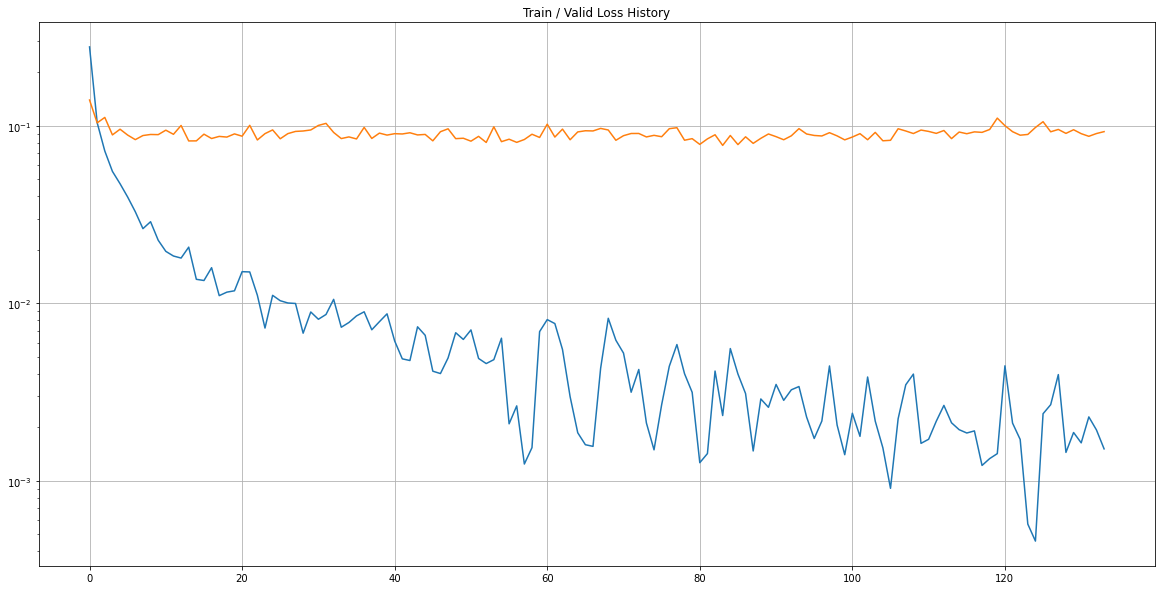

In [11]:
plot_from = 0

plt.figure(figsize=(20, 10))
plt.grid(True)
plt.title("Train / Valid Loss History")
plt.plot(
    range(plot_from, len(train_history)), train_history[plot_from:],
    range(plot_from, len(valid_history)), valid_history[plot_from:],
)
plt.yscale('log')
plt.show()

## 결과 확인

In [12]:
test_loss = 0
y_hat = []

model.eval()
with torch.no_grad():
    x_ = x[-1].split(batch_size, dim=0)
    y_ = y[-1].split(batch_size, dim=0)

    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = crit(y_hat_i, y_i.squeeze())

        test_loss += loss # Gradient is already detached.

        y_hat += [y_hat_i]

test_loss = test_loss / len(x_)
y_hat = torch.cat(y_hat, dim=0)

print("Test loss: %.4e" % test_loss)

Test loss: 8.6111e-02


In [13]:
correct_cnt = (y[-1].squeeze() == torch.argmax(y_hat, dim=-1)).sum()
total_cnt = float(y[-1].size(0))

print('Accuracy: %.4f' % (correct_cnt / total_cnt))

Accuracy: 0.9833


- ERR을 통해 상대적인 모델의 개선 폭을 측정할 수 있다.

In [14]:
import pandas as pd
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(y[-1], torch.argmax(y_hat, dim=-1)),
             index=['true_%d' % i for i in range(10)],
             columns=['pred_%d' % i for i in range(10)])

,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9
true_0,975,1,1,0,0,1,1,1,0,0
true_1,0,1126,1,2,0,0,3,0,3,0
true_2,2,1,1020,0,1,1,1,3,3,0
true_3,1,0,6,993,0,2,0,4,2,2
true_4,1,2,1,0,963,0,4,2,0,9
true_5,2,0,1,7,2,869,4,1,5,1
true_6,2,2,0,1,2,3,948,0,0,0
true_7,0,7,11,1,0,0,1,998,5,5
true_8,3,0,2,3,2,3,1,2,953,5
true_9,2,3,0,2,8,1,0,3,2,988
